# Run on real data

This requires having [run Tangram](https://squidpy.readthedocs.io/en/stable/notebooks/tutorials/tutorial_tangram.html). We propose a run in `run_tangram.py` that includes adding segmentation from QuPath. The following code starts from the endpoint of Tangram already having generated cell typing per cell but randomly allocated (in `per_cell.csv`). And also having some morphology, in this case, already from the QuPath measurements (`measurements.csv`).

In [1]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Load data

In [2]:
measurements = pd.read_csv('measurements.csv')
measurements['Centroid X µm']*=1.3125
measurements['Centroid Y µm']*=1.3125
measurements=measurements.rename(columns={'Centroid X µm':'x', 'Centroid Y µm':'y'})
measurements=measurements.iloc[:,6:26]
measurements[['x','y']]=measurements[['x','y']].astype(int)
measurements.head()

,x,y,Nucleus: Area,Nucleus: Perimeter,Nucleus: Circularity,Nucleus: Max caliper,Nucleus: Min caliper,Nucleus: Eccentricity,Nucleus: Hematoxylin OD mean,Nucleus: Hematoxylin OD sum,Nucleus: Hematoxylin OD std dev,Nucleus: Hematoxylin OD max,Nucleus: Hematoxylin OD min,Nucleus: Hematoxylin OD range,Nucleus: Eosin OD mean,Nucleus: Eosin OD sum,Nucleus: Eosin OD std dev,Nucleus: Eosin OD max,Nucleus: Eosin OD min,Nucleus: Eosin OD range
0,7156,6782,35.9936,23.6512,0.8086,8.2728,6.0823,0.7279,0.4946,31.6565,0.1507,0.9179,0.2603,0.6576,-0.1094,-7.0043,0.0598,0.0209,-0.2550,0.2759
1,7111,6786,35.9936,24.3329,0.7639,8.4984,6.3719,0.5236,0.3908,26.5741,0.1448,0.7821,0.1446,0.6375,-0.1605,-10.9162,0.1158,0.1690,-0.3753,0.5443
2,7283,6786,35.4131,24.2790,0.7549,9.8109,5.0829,0.8852,0.5462,35.5015,0.2324,1.1658,0.2085,0.9573,-0.0986,-6.4065,0.0759,0.0366,-0.2848,0.3214
3,7307,6789,32.5104,20.9505,0.9308,8.2976,5.1150,0.7552,0.6228,34.8744,0.2919,1.2843,0.2624,1.0218,-0.2371,-13.2773,0.1102,0.0142,-0.4749,0.4891
4,7382,6801,114.9474,44.1042,0.7426,15.6610,10.7396,0.7573,0.4866,98.7756,0.1360,0.7944,0.2242,0.5702,-0.0825,-16.7569,0.0762,0.0799,-0.2210,0.3010


In [3]:
per_cell = pd.read_csv('per_cell.csv')
per_cell[['x','y']]=per_cell[['x','y']].astype(int)
per_cell=per_cell.drop(columns=['Unnamed: 0.1','Unnamed: 0'])
per_cell.head()

,x,y,centroids,cluster
0,7060,8044,AAGTTCACTCCAAGCT-1_0,Lamp5
1,7060,8116,AAGTTCACTCCAAGCT-1_1,Sst
2,7110,6962,AATAGAATCTGTTTCA-1_0,Vip
3,7134,6972,AATAGAATCTGTTTCA-1_1,Vip
4,7108,7000,AATAGAATCTGTTTCA-1_2,Vip


In [4]:
df = pd.merge(per_cell, measurements, on=['x','y'], how='left')

In [5]:
scaler = StandardScaler()
B = df.iloc[:,4:].values
B = scaler.fit_transform(B)
print(B.shape)

(65, 18)


In [6]:
X_perm = pd.Categorical(df.cluster).codes
print(X_perm.shape)

(65,)


In [7]:
df['short_centroids'] = df['centroids'].str.split('-1').str[0]
encoder = OneHotEncoder(sparse_output=False)
A = encoder.fit_transform(df[['short_centroids']]).T
print(A.shape)

(28, 65)


## Run method

In [8]:
from celltype_permutation import hierarchical_permutations

In [ ]:
X_global = hierarchical_permutations(A, X_perm, B)

## Evaluate results

In [10]:
random_score = []
for i in range(10000):
    X_list = []
    for (Am, Xm) in zip(A,A*X_perm):
        Xm_sh = Xm[Am>0]
        random.shuffle(Xm_sh)
        X_list.append(Xm_sh)
    X_list = np.hstack(X_list)
    random_score.append(davies_bouldin_score(B, X_list))

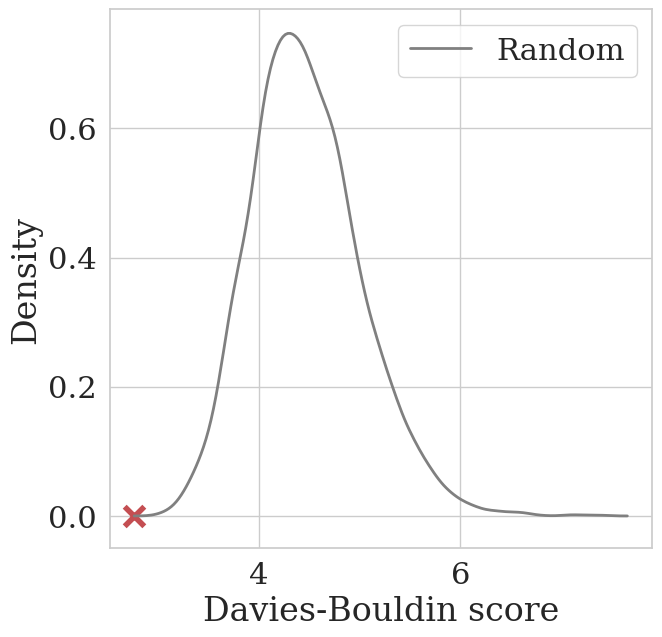

In [11]:
sns.set(font_scale=2, font='serif', style='whitegrid')
plt.figure(figsize=(7,7))
sns.kdeplot(random_score,linewidth=2, color='gray', label='Random')
plt.scatter(davies_bouldin_score(B, X_global),0,marker='x',s=200, c='r',linewidths=4)
plt.xlabel('Davies-Bouldin score')
plt.ylim(-0.05, )
plt.legend()